In [ ]:
!pip install --upgrade fastrank lightgbm==3.1.1
!pip install python-terrier
# !pip install --upgrade git+https://github.com/Georgetown-IR-Lab/OpenNIR
# !pip install --upgrade git+https://github.com/terrierteam/pyterrier_doc2query.git

     |████████████████████████████████| 891 kB 26.4 MB/s 
     |████████████████████████████████| 1.8 MB 66.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 95 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 47.4 MB/s 
     |████████████████████████████████| 69 kB 7.7 MB/s 
     |████████████████████████████████| 255 kB 52.4 MB/s 
     |████████████████████████████████| 41 kB 295 kB/s 
     |████████████████████████████████| 6.3 MB 45.6 MB/s 
     |████████████████████████████████| 1.8 MB 36.4 MB/s 
     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 294 kB 50.3 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 126 kB 44.9 MB/s 
     |████████████████████████████████| 291 kB 46.6 MB/s 
     |██████████████████████████████

In [ ]:
import pyterrier as pt
import pandas as pd
import os
# import onir_pt

In [ ]:
if not pt.started():
    pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.7.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving final_documents.csv to final_documents.csv


In [ ]:
df = pd.read_csv('final_documents.csv') 
df['docno'] = df.docno.astype(str)
df['rating'] = df.rating.astype(str)
df['review_text_1'] = df.review_text_1.astype(str)
df['review_time_1'] = df.review_time_1.astype(str)
df['review_text_2'] = df.review_text_2.astype(str)
df['review_time_2'] = df.review_time_2.astype(str)
df['review_text_3'] = df.review_text_3.astype(str)
df['review_time_3'] = df.review_time_3.astype(str)
df['review_text_4'] = df.review_text_4.astype(str)
df['review_time_4'] = df.review_time_4.astype(str)
df['review_text_5'] = df.review_text_5.astype(str)
df['review_time_5'] = df.review_time_5.astype(str)
df.head()

,docno,place_id,name,map_name,state,lat,lng,title,description,rating,review_text_1,review_time_1,review_text_2,review_time_2,review_text_3,review_time_3,review_text_4,review_time_4,review_text_5,review_time_5
0,1,ChIJ_VVXImAMyFYRnus7r5Dykqs,26 Glacier Cruise,26 Glacier Cruise,Alaska,60.777823,-148.697484,"26 Glacier Cruise - Whittier, Alaska - Alaska ...",26 Glacier Cruise takes passengers around the ...,4.8,Fantastic experience! The pictures attached to...,1636781828.0,The cruise so worth and highly recommend if an...,1630602901.0,Booked the 26 Glaciers but changed to the shor...,1629765328.0,One of our best tour experiences during our vi...,1626901581.0,OMG! My family and I had an amazing Time on th...,1626768663.0
1,2,ChIJH0jnvSmWyFYRXV2yOkGp6Ac,5th Avenue Mall,Anchorage 5th Avenue Mall,Alaska,61.216889,-149.888942,"5th Avenue Mall - Anchorage, Alaska - Shopping...",5th Avenue Mall is located at West 5th Avenue ...,4.2,"While there are many vacancies currently, this...",1636418825.0,Pretty good... I haven't been here for years. ...,1637807843.0,Visited my favorite shoe store (The Alaska Wal...,1619913101.0,Location is prime. This place has the best loc...,1626155621.0,I truly value my bi-weekly visits here! The su...,1636152161.0
2,3,ChIJyYLv3YLfAFQRwdhiwYC5zcQ,A Gallery in Juneau,Juneau Artists Gallery Ltd,Alaska,58.300215,-134.404656,A Gallery in Juneau,"Like many cities in Alaska, Juneau has numerou...",4.5,"Great assortment of local artist works, with a...",1638149268.0,Great place for local artists.,1636178619.0,Great local artwork and jewelry. Stop in and ...,1554835391.0,This store sells locally crafted items such as...,1518289597.0,Visited while on vacation fun place,1506443215.0
3,4,ChIJjUPnbCmWyFYRr_lSUBrKRVc,A Part of the Anchorage Museum,Anchorage Museum,Alaska,61.216228,-149.885579,A Part of the Anchorage Museum,The Rasmussen Center is the portion of the Anc...,4.5,Shockingly wonderful! We had a great experienc...,1634888805.0,The Anchorage Museum was fantastic! We were fo...,1637977833.0,One of the more culturally and globally aware ...,1638073297.0,"A very good regional museum, encompassing art,...",1629402829.0,The exterior and interior design of the museum...,1632588328.0
4,5,ChIJhbwvNU97yFYRtKJsGzJuMXw,"A Rugged, But Beautiful Adventure",Alaska Wildland Adventures,Alaska,60.961173,-149.145260,"A Rugged, But Beautiful Adventure",Switchback Trail is a hiking trail not for the...,4.3,We recently stayed at the Kenai Fjords Glacier...,1629992829.0,"Everything is top-notch, A1 here! Guides are f...",1622805819.0,Awesome day of guided fishing on the Upper Ken...,1536624163.0,Beautiful lodges in spectacular locations with...,1532641243.0,A great company to work for!,1555657216.0


In [ ]:
pd_indexer = pt.DFIndexer("./pd_index", overwrite=True, blocks=True)
indexref = pd_indexer.index(df["description"], df["docno"], 
                            df["map_name"], df["title"], df["rating"], 
                            df["review_text_1"], df["review_time_1"],
                            df["review_text_2"], df["review_time_2"],
                            df["review_text_3"], df["review_time_3"],
                            df["review_text_4"], df["review_time_4"],
                            df["review_text_5"], df["review_time_5"],)

In [ ]:
index = pt.IndexFactory.of(indexref)
print(index.getCollectionStatistics().toString())

Number of documents: 13891
Number of terms: 42016
Number of postings: 1855998
Number of fields: 0
Number of tokens: 2708372
Field names: []
Positions:   true



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Query.csv to Query.csv


In [ ]:
topics = pd.read_csv('Query.csv') 
topics['qid'] = topics.qid.astype('str')
topics.head()

,qid,query
0,1,A place where you can see various kinds of ani...
1,2,A park with trees everywhere
2,3,A beautiful place with waterfalls
3,4,A playground suitable for family entertainment
4,5,A city with many art-focused museums


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving qrel.csv to qrel.csv


In [ ]:
qrels = pd.read_csv('qrel.csv') 
qrels['qid'] = qrels.qid.astype(str)
qrels['docno'] = qrels.docno.astype(str)
qrels.head()

,qid,docno,label
0,1,9837,5
1,1,572,5
2,1,12369,5
3,1,4629,5
4,1,811,5


In [ ]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
br = pt.BatchRetrieve(index)
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

In [ ]:
RANK_CUTOFF = 100
SEED=42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=9, random_state=SEED)
train_topics, valid_topics = train_test_split(tr_va_topics, test_size=3, random_state=SEED)

In [ ]:
ltr_feats_0 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of map_name
    (pt.text.scorer(body_attr="map_name", wmodel='BM25') ) 
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["rating"]=="nan" else float(row["rating"])))
    ** # score of reviews
    (pt.text.scorer(body_attr="review_text_1", wmodel='BM25') + 
     pt.text.scorer(body_attr="review_text_2", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_3", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_4", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_5", wmodel='BM25') )
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)
                                                             
# for reference, lets record the feature names here too
fnames=["BM25", "SDM", "map_name", "title", "rating", "reviews", "CoordinateMatch"]

In [ ]:
ltr_feats_1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["rating"]=="nan" else float(row["rating"])))
    ** # score of reviews
    (pt.text.scorer(body_attr="review_text_1", wmodel='BM25') + 
     pt.text.scorer(body_attr="review_text_2", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_3", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_4", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_5", wmodel='BM25') )
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [ ]:
ltr_feats_2 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of map_name
    (pt.text.scorer(body_attr="map_name", wmodel='BM25') ) 
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # score of reviews
    (pt.text.scorer(body_attr="review_text_1", wmodel='BM25') + 
     pt.text.scorer(body_attr="review_text_2", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_3", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_4", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_5", wmodel='BM25') )
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [ ]:
ltr_feats_3 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of map_name
    (pt.text.scorer(body_attr="map_name", wmodel='BM25') ) 
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["rating"]=="nan" else float(row["rating"])))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [ ]:
ltr_feats_4 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # score of reviews
    (pt.text.scorer(body_attr="review_text_1", wmodel='BM25') + 
     pt.text.scorer(body_attr="review_text_2", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_3", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_4", wmodel='BM25') +
     pt.text.scorer(body_attr="review_text_5", wmodel='BM25') )
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [ ]:
ltr_feats_5 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # rating
    (pt.apply.doc_score(lambda row: 0 if row["rating"]=="nan" else float(row["rating"])))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [ ]:
ltr_feats_6 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of map_name
    (pt.text.scorer(body_attr="map_name", wmodel='BM25') ) 
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [ ]:
ltr_feats_7 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of title
    (pt.text.scorer(body_attr="title", wmodel='BM25') ) 
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

In [ ]:
feature_eval = pt.Experiment(
    [ltr_feats_0 >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_100", "P_30", "recall_30", "mrt"])
feature_eval.to_csv("feature_eval.csv")
files.download('feature_eval.csv')

21:48:48.580 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:48:49.009 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:48:49.536 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:48:50.061 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e90>, <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80d90>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


21:48:56.494 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:48:56.928 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:48:57.448 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:48:57.981 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e90>, <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80d90>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


21:49:04.396 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:04.829 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:05.361 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:05.896 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e90>, <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80d90>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


21:49:12.289 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:12.714 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:13.252 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:13.778 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e90>, <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80d90>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


21:49:20.229 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:20.658 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:21.189 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:21.794 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e90>, <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80d90>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


21:49:28.351 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:28.788 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:29.316 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:29.842 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e90>, <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80d90>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


21:49:36.447 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:36.879 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:37.414 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:49:37.940 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e90>, <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80d90>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80e10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f10>), <pyterrier.batchretrieve.TextScorer object at 0x7f3827b80f90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567
qrels['label'] = qrels.label.astype(float)
ca_pipe0 = ltr_feats_0 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe0.fit(train_topics, qrels)
ca_pipe1 = ltr_feats_1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe1.fit(train_topics, qrels)
ca_pipe2 = ltr_feats_2 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe2.fit(train_topics, qrels)
ca_pipe3 = ltr_feats_3 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe3.fit(train_topics, qrels)
ca_pipe4 = ltr_feats_4 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe4.fit(train_topics, qrels)
ca_pipe5 = ltr_feats_5 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe5.fit(train_topics, qrels)
ca_pipe6 = ltr_feats_6 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe6.fit(train_topics, qrels)
ca_pipe7 = ltr_feats_7 >> pt.ltr.apply_learned_model(train_request, form='fastrank')
%time ca_pipe7.fit(train_topics, qrels)

13:06:24.818 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:26.221 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:27.752 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:29.339 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af50>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af90>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79090>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79110>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79190>), expected 1800 received 85, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScore

CPU times: user 30.6 s, sys: 509 ms, total: 31.1 s
Wall time: 22.8 s
13:06:46.464 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:47.750 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:49.194 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:06:50.684 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no te

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8db90>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8dbd0>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8db10>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8dc10>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8dc90>), expected 1800 received 85, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScore

CPU times: user 21.1 s, sys: 276 ms, total: 21.4 s
Wall time: 18.6 s
13:07:03.797 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:04.840 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:06.127 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:07.607 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no te

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82bd0>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82c10>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82b50>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82c50>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82cd0>), expected 1800 received 85, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScore

CPU times: user 19.4 s, sys: 253 ms, total: 19.7 s
Wall time: 18.2 s
13:07:22.165 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:23.199 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf91250>, expected 1800 received 511, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 12.4 s, sys: 246 ms, total: 12.6 s
Wall time: 11.4 s
13:07:33.366 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:34.659 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:35.999 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:07:37.394 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no te

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd290>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd510>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd610>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd410>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd4d0>), expected 1800 received 85, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScore

CPU times: user 17.9 s, sys: 157 ms, total: 18 s
Wall time: 16.9 s
13:07:50.638 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf919d0>, expected 1800 received 511, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 11.4 s, sys: 239 ms, total: 11.6 s
Wall time: 10.4 s
13:08:00.759 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:08:01.802 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf5df90>, expected 1800 received 511, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 12.3 s, sys: 110 ms, total: 12.4 s
Wall time: 11.1 s
13:08:11.754 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8a490>, expected 1800 received 511, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 10 s, sys: 92.4 ms, total: 10.1 s
Wall time: 9.58 s


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats_0 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, qrels)

13:08:48.978 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:08:50.032 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:08:51.299 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:08:52.649 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af50>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af90>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79090>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79110>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79190>), expected 1800 received 85, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScore

CPU times: user 20.4 s, sys: 276 ms, total: 20.7 s
Wall time: 19 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    1.8s finished


In [ ]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[100],
    ndcg_at=[100],
    eval_at=[100],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=500,
    early_stopping_rounds=40
)

lmart_pipe0 = ltr_feats_0 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
%time lmart_pipe0.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe1 = ltr_feats_1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe1.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe2 = ltr_feats_2 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe2.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe3 = ltr_feats_3 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe3.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe4 = ltr_feats_4 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe4.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe5 = ltr_feats_5 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe5.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe6 = ltr_feats_6 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe6.fit(train_topics, qrels, valid_topics, qrels)
# lmart_pipe7 = ltr_feats_7 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})
# %time lmart_pipe7.fit(train_topics, qrels, valid_topics, qrels)

13:11:36.503 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:37.525 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:38.880 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:40.250 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af50>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af90>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79090>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79110>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79190>), expected 1800 received 85, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScore

13:11:47.256 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:47.508 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:47.806 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:11:48.111 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af50>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af90>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79090>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79110>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79190>), expected 300 received 27, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Foun

[LightGBM] [Warning] early_stopping_round is set=40, early_stopping_rounds=40 will be ignored. Current value: early_stopping_round=40
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 7
[

In [ ]:
qrels['label'] = qrels.label.astype(int)
pipe1 = sdm >> bm25
pipe2 = bm25 >> qe >> bm25
table = pt.Experiment(
    [br % RANK_CUTOFF, bm25 % RANK_CUTOFF, tf_idf % RANK_CUTOFF, tf % RANK_CUTOFF, ca_pipe0, ca_pipe1, ca_pipe2, ca_pipe3, ca_pipe4, ca_pipe5, ca_pipe6, ca_pipe7, lmart_pipe0, rf_pipe, pipe1, pipe2], 
    test_topics, 
    qrels, 
    names=["BR", "BM25", "TF-IDF", "TF", "BM25+CA0", "BM25+CA1", "BM25+CA2", "BM25+CA3", "BM25+CA4", "BM25+CA5", "BM25+CA6", "BM25+CA7", "BM25+LMART", "BM25+RF", "Pipeline 1", "Pipeline 2"], 
    eval_metrics=["map", "ndcg", "ndcg_cut_100", "P_30", "recall_30", "mrt"])
table.to_csv("evaluation.csv")

13:12:06.889 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:07.475 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:08.191 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:08.888 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af50>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af90>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79090>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79110>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79190>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


13:12:15.980 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:16.712 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:17.409 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:18.103 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8db90>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8dbd0>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8db10>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8dc10>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf8dc90>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


13:12:24.606 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:25.185 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:25.858 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:26.549 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82bd0>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82c10>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82b50>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82c50>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf82cd0>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


13:12:33.855 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:34.415 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:39.614 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:40.338 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd290>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd510>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd610>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd410>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc7cbbd4d0>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


13:12:48.018 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:53.133 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:53.710 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:12:58.523 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af50>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af90>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79090>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79110>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79190>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


13:13:12.447 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:13.000 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:13.703 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:13:14.393 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

/usr/local/lib/python3.7/dist-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from CombSumTransformer(CombSumTransformer(CombSumTransformer(CombSumTransformer(<pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af50>, <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf7af90>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79090>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79110>), <pyterrier.batchretrieve.TextScorer object at 0x7fcc6cf79190>), expected 900 received 19, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: 

In [ ]:
files.download('evaluation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

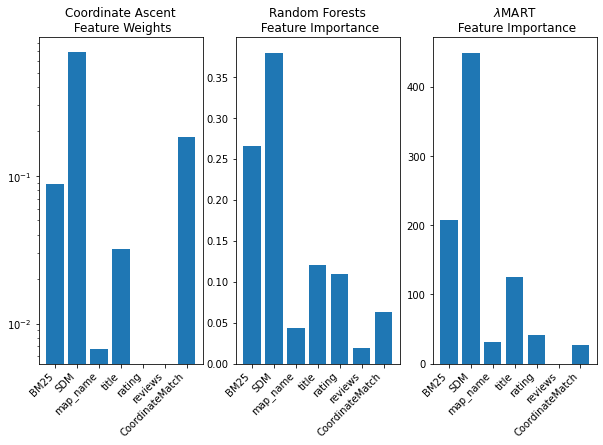

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe0[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()

In [ ]:
# knrm = onir_pt.reranker('knrm', 'wordvec_hash', text_field=["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"])
# pipeline_knrm = bm25 >> pt.text.get_text(index, ["map_name", "title", "rating", "review_text_1", "review_text_2", "review_text_3", "review_text_4", "review_text_5"]) >> knrm
# pipeline_knrm.fit(
#     train_topics,
#     qrels,
#     valid_topics,
#     qrels)

In [ ]:

# pt.Experiment(
#     [br, bm25, pipeline_knrm],
#     test_topics,
#     qrels,
#     names=['DPH', 'BM25', 'KNRM'],
#     eval_metrics=["map", "ndcg", 'ndcg_cut_100', 'mrt']
# )